In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy

In [2]:
# Data from Goto et al. 2009, digitized with https://apps.automeris.io/wpd/
hnb_Mg_0mM = pd.read_csv("hnb_Mg_0mM.csv",names=["wavelength","Aborbance, HNB, Mg2+ 0 mM"], index_col=0)
hnb_Mg_8mM = pd.read_csv("hnb_Mg_8mM.csv",names=["wavelength","Aborbance, HNB, Mg2+ 8 mM"], index_col=0)

In [3]:
# Data from https://raw.githubusercontent.com/khufkens/pi-camera-response-curves/master/Sony_IMX219_spectral_response.csv
camera = pd.read_csv("Sony_IMX219_spectral_response.csv", index_col=0)
camera.index = camera.index.astype(float)
camera /= 100.0

In [4]:
# Modified from https://github.com/axr6077/ParticleTrajectory/blob/dce4e5ee9f1492ccc4816632c7dbf0d47651e7e6/Python%20Scripts/spectrum.py
def black_body(wavelengths, T):
    from scipy.constants import h, c, k

    l = wavelengths * 1e-9
    energy_density = 2 * h * c ** 2 / l ** 5 * 1.0 / (np.exp(h * c / (l * k * T)) - 1.0)
    energy_density /= np.max(energy_density)
    return energy_density
        

In [5]:
df = pd.merge_ordered(left=hnb_Mg_0mM, right=hnb_Mg_8mM, on='wavelength')
df = pd.merge_ordered(left=df, right=camera, on='wavelength')

df.set_index('wavelength',inplace=True)
df.interpolate(inplace=True)

In [6]:
# Sunlight has a color temperature of ~5800K
df["5800K"] = black_body(df.index.values,5800)

In [7]:
# convert absorbance to transmittance
df["HNB, Mg2+ 0 mM"] = np.power(10.0,-df["Aborbance, HNB, Mg2+ 0 mM"].values)
df["HNB, Mg2+ 8 mM"] = np.power(10.0,-df["Aborbance, HNB, Mg2+ 8 mM"].values)
df.drop(columns=["Aborbance, HNB, Mg2+ 0 mM","Aborbance, HNB, Mg2+ 8 mM"],inplace=True)

In [8]:
# Since we don't have data outside the interval (400,700) for the camera, 
# limit analysis to this range.
df = df[ df.index >= 400 ]
df = df[ df.index <= 700 ]

<IPython.core.display.Javascript object>


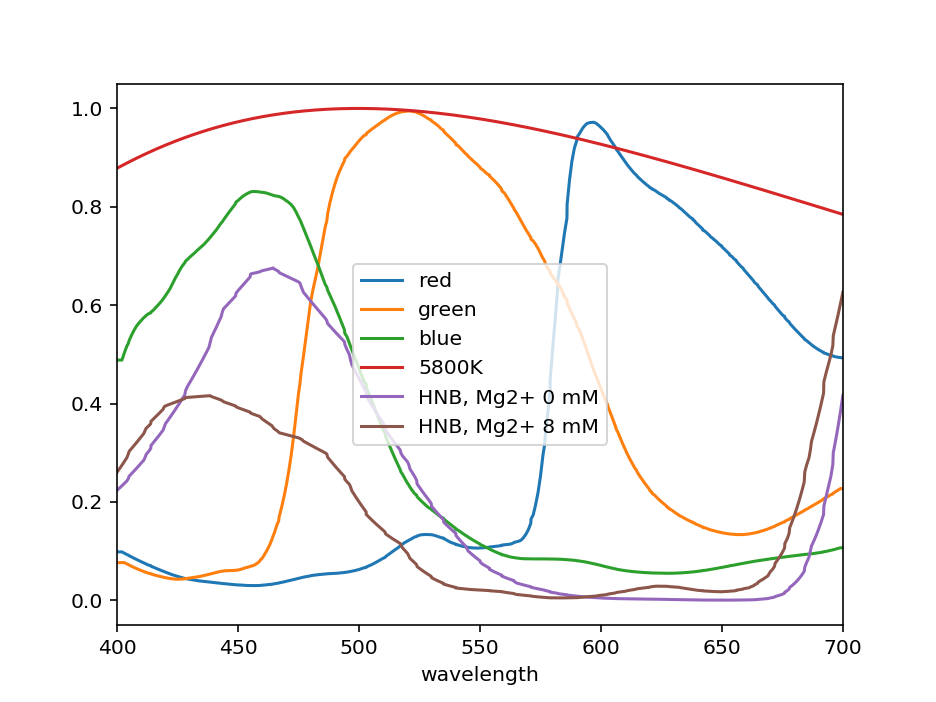

In [9]:
df.plot();

In [10]:
zero = []
full = []
for channel in ["red","green","blue"]:
    zero.append((df["HNB, Mg2+ 0 mM"]*df["5800K"]*df[channel]).sum())
    full.append((df["HNB, Mg2+ 8 mM"]*df["5800K"]*df[channel]).sum())

<IPython.core.display.Javascript object>


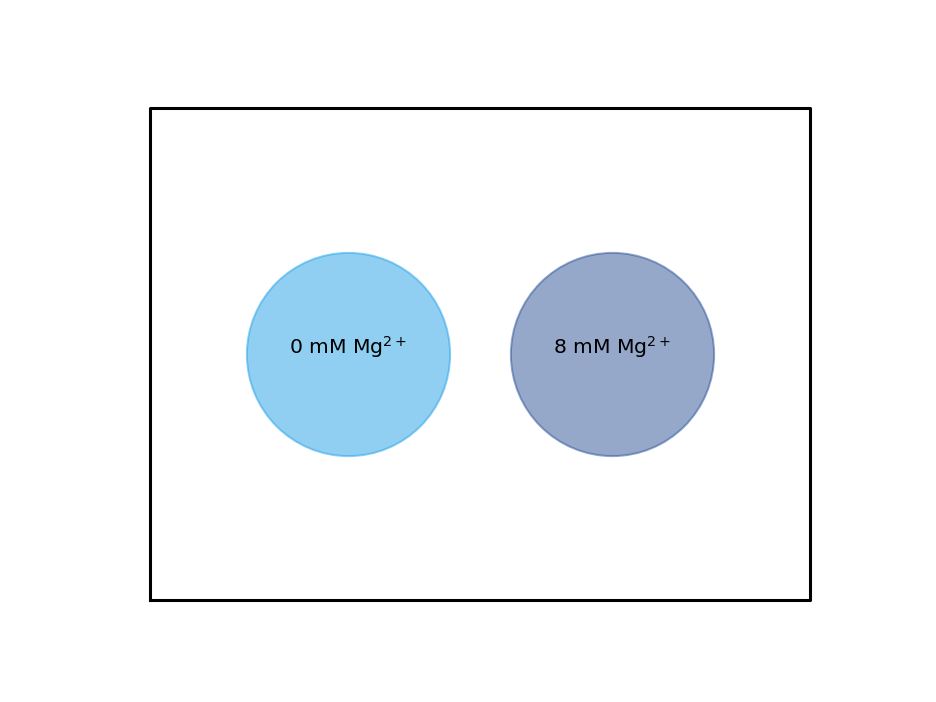

In [11]:
# Scale: first term to make brighter, second term to put in interval (0,1) as a float.
scale = 5.0/255.0

fig, ax = plt.subplots(frameon=False)
ax.plot([0.3],[0.5],marker='o',markersize=100.0,color=np.array(zero)*scale,alpha=0.5)
ax.text(0.3,0.5,'0 mM Mg$^{2+}$',horizontalalignment='center')
ax.plot([.7],[0.5],marker='o',markersize=100.0,color=np.array(full)*scale,alpha=0.5)
ax.text(.7,0.5,'8 mM Mg$^{2+}$',horizontalalignment='center')
ax.plot([0.0, 1.0, 1.0, 0.0, 0.0],[0.0, 0.0, 1.0, 1.0, 0.0],'k-')

ax.axis('off');

## Comparing our prediction with a real digital image.

Let's compare the prediction above with a real digital image of HNB with varying Mg2+ concentration.

![Kellner-2020-Fig5D.png](Kellner-2020-Fig5D.png)

Photo from: A rapid, highly sensitive and open-access SARS-CoV-2 detection assay for laboratory and home testing
Max J. Kellner, James J. Ross, Jakob Schnabl, Marcus P.S. Dekens, Robert Heinen, Irina Grishkovskaya, Benedikt Bauer, Johannes Stadlmann, Luis Menéndez-Arias, Robert Fritsche-Polanz, Marianna Traugott, Tamara Seitz, Alexander Zoufaly, Manuela Födinger, Christoph Wenisch, Johannes Zuber, Vienna Covid-19 Diagnostics Initiative (VCDI), Andrea Pauli, Julius Brennecke
bioRxiv 2020.06.23.166397; doi: https://doi.org/10.1101/2020.06.23.166397 
